In [23]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from multiprocessing import shared_memory
import pytorch_lightning as pl

import importlib
import training_code
import Utilities
importlib.reload(training_code)
importlib.reload(Utilities)
from Utilities import LogDataset
from training_code import LitModel, CustomBERT, get_dataset

load and check the complete dataset

In [24]:
data_ = pd.read_csv(r"Dataset/out/parsed_HDFS_.log_structured.csv", low_memory=False).values
data_shared_memory = shared_memory.SharedMemory(create=True, size=data_.nbytes)
data_np = np.ndarray(data_.shape, dtype=data_.dtype, buffer=data_shared_memory.buf)
np.copyto(data_np, data_)
dataset = LogDataset(400, shared_memory=data_np)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

load dataset and split to train and test

In [25]:
train_dataset, test_dataset, train_idx, test_idx = get_dataset(dataset, 40)
dataset[0]
pass

check if model works

In [26]:
_, _, temp, _ = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=3, collate_fn=dataset.collate_fn, shuffle=True)))
with torch.no_grad():
    eye_matrix = np.eye(int(399))
    res = CustomBERT().forward(temp[0],temp[1], len(temp[0][0])//2)
    print(res[0].shape, res[1].shape, 
          "\n",
          *[a.shape 
            for a in LitModel().to_loss_ready(temp[0], temp[1])])

torch.Size([3, 400, 7, 399]) torch.Size([3, 400, 2, 1]) 
 torch.Size([3, 400, 7, 399]) torch.Size([3, 400, 2, 1])


train model

In [27]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, collate_fn=dataset.collate_fn, shuffle=True)  #, num_workers=6, persistent_workers=True)
model = LitModel(lr=0.1).to(float).to('cuda')
trainer = pl.Trainer(accumulate_grad_batches=1, max_epochs=20)
trainer.fit(model, data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: D:\User\App Files\Projects\VUB-ACS-24_OS\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | CustomBERT       | 5.0 M 
1 | criterion_class  | CrossEntropyLoss | 0     
2 | criterion_scaler | MSELoss          | 0     
------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.878    Total estimated model params size (MB)
D:\User\Software\MiniConda3\envs\SuperCondaEnv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


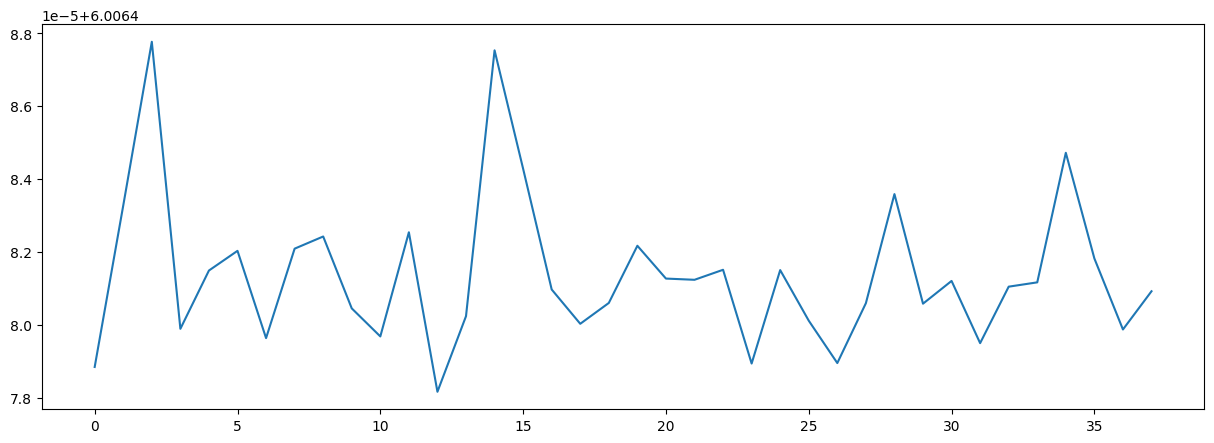

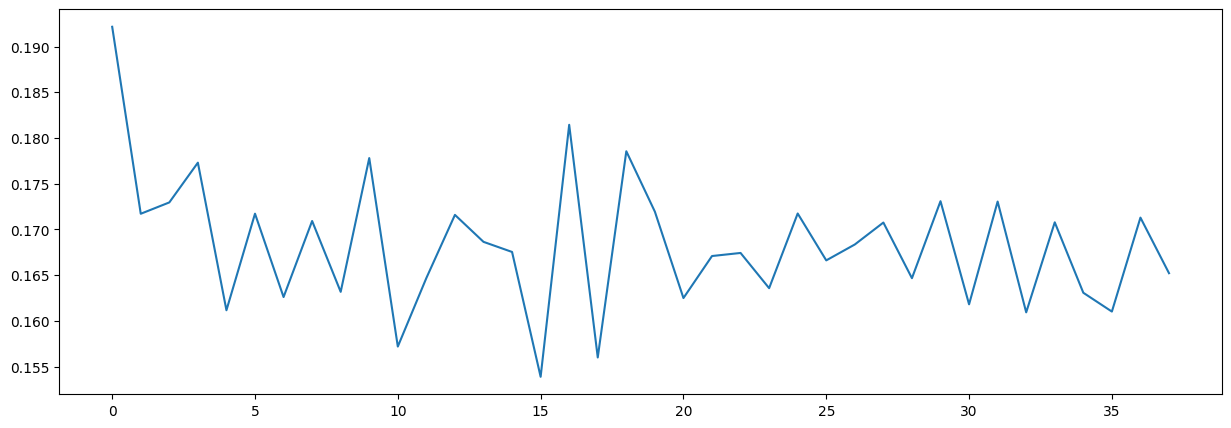

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(np.array(model.loss_history[0][1:-1]))
# plt.ylim(0.75, 0.86)
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(np.array(model.loss_history[1][1:-1]))
plt.show()

In [40]:
# save their weight, data, index, everything
# torch.save({
#     'model': model.state_dict(),
#     'train_idx': train_idx,
#     'test_idx': test_idx,
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset,
#     'dataset': dataset,
#     'loss_history': model.loss_history
# }, "model.pth")

In [9]:
# load
checkpoint = torch.load("model.pth")
model = LitModel().to(float).to('cuda')
model.load_state_dict(checkpoint['model'])
model.loss_history = checkpoint['loss_history']
train_idx = checkpoint['train_idx']
test_idx = checkpoint['test_idx']
train_dataset = checkpoint['train_dataset']
test_dataset = checkpoint['test_dataset']
dataset = checkpoint['dataset']


In [26]:
middle_idx = dataset.window_length // 2


def get_anomaly_idx_in_subset(subset_dataset, middle_idx):
    subset_idx = subset_dataset.indices
    all_anomaly_idx = np.where(data_np[:, 0])[0] - middle_idx
    subset_anamaly_idx_in_main_dataset = all_anomaly_idx[np.in1d(all_anomaly_idx, subset_idx, assume_unique=True)]
    return np.where(np.in1d(subset_idx, subset_anamaly_idx_in_main_dataset, assume_unique=True))[0]

In [27]:
def test_model(model, subset_dataset, middle_idx, anomaly, size_):
    model.eval()
    dataset = subset_dataset.dataset
    with torch.no_grad():
        if anomaly:
            subset_dataset.dataset.give_what = 'anomaly'
            _, _, data, _ = next(iter(torch.utils.data.DataLoader(
                torch.utils.data.Subset(subset_dataset, get_anomaly_idx_in_subset(subset_dataset, middle_idx)),
                batch_size=size_, collate_fn=dataset.collate_fn, shuffle=True
            )))
        else:
            subset_dataset.dataset.give_what = 'normal'
            _, _, data, _ = next(iter(torch.utils.data.DataLoader(
                torch.utils.data.Subset(dataset, subset_dataset.indices),
                batch_size=size_, collate_fn=dataset.collate_fn, shuffle=True
            )))

        res = model((data[0].to('cuda'), data[1].to('cuda').to(float)))
        res = [res[0][:, middle_idx].cpu().to(float), res[1][:, middle_idx].cpu()]
        res = [torch.topk(res[0], 5).indices, res[1]]
        data = (data[0][:, middle_idx].cpu().to(float), data[1][:, middle_idx].cpu())

    scalar_error = ((data[1] - res[1][:, :, 0]) ** 2).numpy()
    class_error = np.stack([data[0]] * 5).transpose(1, 2, 0) == res[0].numpy()
    class_error = np.array([a.sum(1) for a in class_error])

    dataset.give_what = 'normal'
    return np.concatenate([scalar_error, class_error], axis=1), data


temp = test_model(model, test_dataset, middle_idx, anomaly=True, size_=30)

In [28]:
temp[0]

array([[0.78747518, 0.37704182, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.16786074, 0.37778961, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.16776943, 0.37796749, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [39]:
np.concatenate(temp[1], 1)

array([[1.00000000e+00, 7.00000000e+01, 0.00000000e+00, 5.50000000e+01,
        0.00000000e+00, 0.00000000e+00, 9.30000000e+01, 2.61264368e-01,
        0.00000000e+00],
       [3.00000000e+00, 5.20000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.22497388e-01,
        0.00000000e+00],
       [5.00000000e+00, 9.00000000e+00, 2.90000000e+01, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.22497388e-01,
        0.00000000e+00],
       [4.00000000e+00, 1.02000000e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.30000000e+01, 0.00000000e+00, 5.22497388e-01,
        1.00000000e+00],
       [1.00000000e+00, 8.00000000e+01, 0.00000000e+00, 2.50000000e+01,
        0.00000000e+00, 0.00000000e+00, 5.80000000e+01, 2.61264368e-01,
        0.00000000e+00],
       [1.00000000e+00, 7.30000000e+01, 0.00000000e+00, 5.30000000e+01,
        0.00000000e+00, 0.00000000e+00, 9.00000000e+00, 2.61264368e-01,
        0.0